# Fraudulent Activity Detection
### Synthetic Financial Datasets For Fraud Detection
https://www.kaggle.com/datasets/ealaxi/paysim1/data


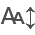

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, classification_report, accuracy_score, precision_score, recall_score, fbeta_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from itables import init_notebook_mode
import numpy as np
import math
from ipywidgets import interact

init_notebook_mode(all_interactive=True)


# Data Exploration

In [2]:
# Load data
data = pd.read_csv("datasets/fraud.csv")


In [3]:
data.describe()


step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
50%      1.327057e+05    2.146614e+05  0.000000e+00    0.000000e+00  
75%      9.430367e+05    1.111909e+06  0.000000e+00    0.000000e+00  
max      3.560159e+08    3.561793e+08  1.000000e+00    1.000000e+00

In [4]:
data.rename(columns={'oldbalanceOrg': 'oldBalanceOrig', 
                     'newbalanceOrig': 'newBalanceOrig', 
                     'oldbalanceDest': 'oldBalanceDest',
                     'newbalanceDest': 'newBalanceDest'}, inplace=True)


In [5]:
# Check for missing values in data
data.isna().sum()


step              0
type              0
amount            0
nameOrig          0
oldBalanceOrig    0
newBalanceOrig    0
nameDest          0
oldBalanceDest    0
newBalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

No missing data, so no need for any cleanup

In [6]:
print("Fraction of Anomalies in dataset: ", data[data.isFraud == 1]["isFraud"].count() / data["isFraud"].count())
data['isFraud'].value_counts()


Fraction of Anomalies in dataset:  0.001290820448180152


isFraud
0    6354407
1       8213
Name: count, dtype: int64

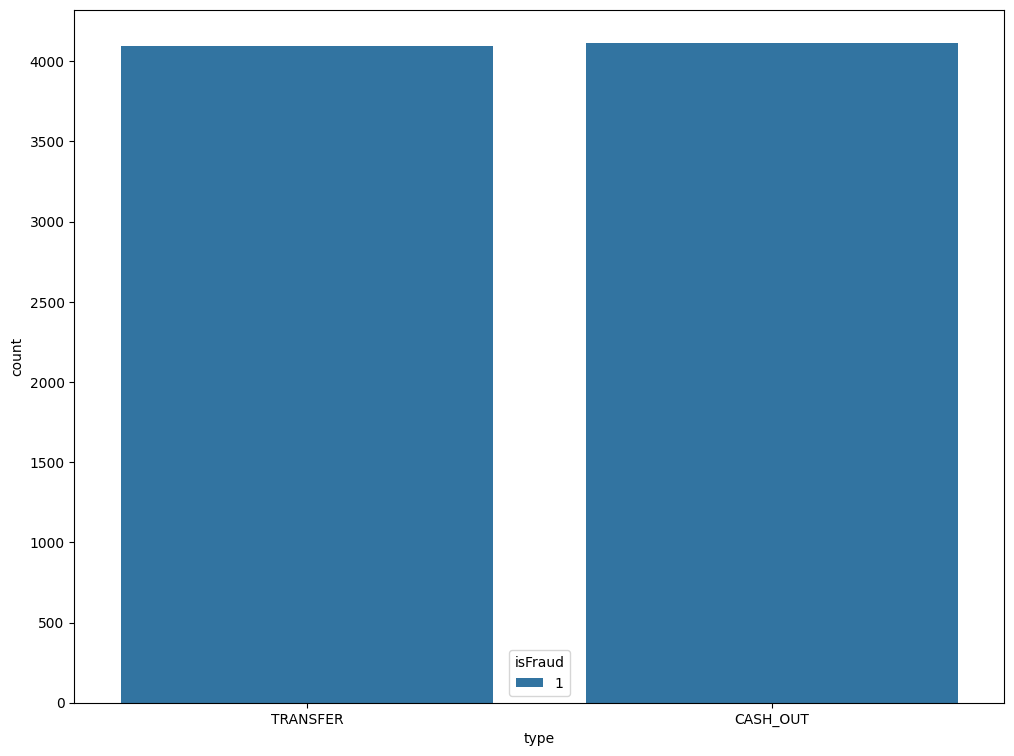

In [7]:
# Observe for which payment types fraud is more likely to be seen
plt.figure(figsize=(12, 9))
sns.countplot(x="type", data=data[data["isFraud"] == 1], hue="isFraud")
plt.show()


TRANSFER and CASH_OUT are the only types where fraudulent activity is detected

array([[<Axes: title={'center': 'oldBalanceOrig'}>]], dtype=object)

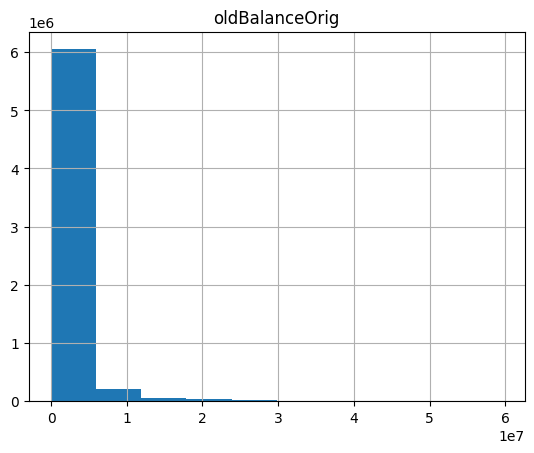

In [8]:
# Observe distribution of balances in source accounts
data.hist(column="oldBalanceOrig")


In [9]:
sample = data.sample(frac=0.01, random_state=42)


In [10]:
def scatter_plot(x, y, c):
    plt.close()
    plt.figure(figsize=(12, 9))
    sns.scatterplot(x=x, y=y, data=sample, hue=c)
    plt.show()


In [11]:
# Observe relationship of attributes
interact(scatter_plot, x=sample.columns, y=sample.columns, c = "isFraud")


interactive(children=(Dropdown(description='x', options=('step', 'type', 'amount', 'nameOrig', 'oldBalanceOrig…

<function __main__.scatter_plot(x, y, c)>

Observations:
* Frauds are found when millions are transferred from accounts with millions in balance.
* Frauds also detected where all amount from account is being transferred at once
* Frauds also when the recipients balance is 0 after transaction (maybe account emptied immediately after transaction)

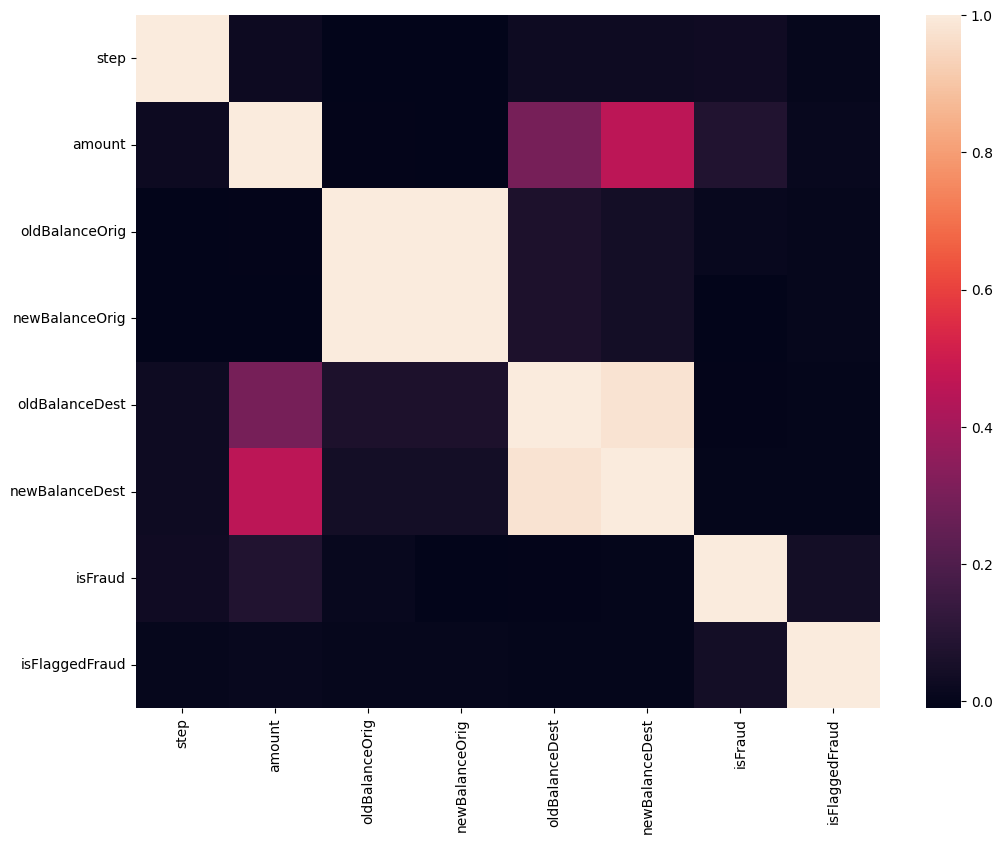

In [12]:
# Plot correlation matrix
plt.figure(figsize=(12, 9))
dataplot = sns.heatmap(data.corr(numeric_only=True)) 
plt.show()


# Feature Engineering

In [14]:
# Extract the type of receiver (strong correlation with isTransfer so skipped)
# data["receiverType"] = data['nameDest'].apply(lambda x: next(filter(str.isalpha, x), ''))
# data["receiverType"] = data['receiverType'].apply(lambda x: 0 if x == "M" else 1)


In [15]:
# One hot encoding of payment types
one_hot_encoded = pd.get_dummies(data['type']).astype(int)

data = pd.concat([data, one_hot_encoded], axis = 1)
data["isTransfer"] = data["TRANSFER"] + data["CASH_OUT"]
data.drop(columns = ['type', 'DEBIT', 'TRANSFER', 'CASH_OUT', 'PAYMENT', 'CASH_IN'], inplace = True)


In [16]:
# Feature extraction
# data["amount_oldbalanceOrg"] = data["amount"] * data["oldbalanceOrg"] * data["isTransfer"]
data["ratioAmountToNewBalanceDest"] = (data["amount"] / (1 + data["newBalanceDest"])) * data["isTransfer"]
data['diffBalanceOrig'] = (data['oldBalanceOrig'] - data['newBalanceOrig']) * data["isTransfer"]
# data['diffBalanceDest'] = (data['newBalanceDest'] - data['oldBalanceDest']) * data["isTransfer"]

# data['errorBalanceOrig'] = (data['newBalanceOrig'] + data['amount'] - data['oldBalanceOrig']) * data["isTransfer"]
data['errorBalanceDest'] = (data['oldBalanceDest'] + data['amount'] - data['newBalanceDest']) * data["isTransfer"]


In [17]:
# Normalize data
def normalize(df):
    for column in df.columns:
        if column in ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']:
            df[column] = zscore(df[column])


In [18]:
# normalize(data)


In [19]:
data


step      amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0           1     9839.64  C1231006815       170136.00       160296.36   
1           1     1864.28  C1666544295        21249.00        19384.72   
2           1      181.00  C1305486145          181.00            0.00   
3           1      181.00   C840083671          181.00            0.00   
4           1    11668.14  C2048537720        41554.00        29885.86   
...       ...         ...          ...             ...             ...   
6362615   743   339682.13   C786484425       339682.13            0.00   
6362616   743  6311409.28  C1529008245      6311409.28            0.00   
6362617   743  6311409.28  C1162922333      6311409.28            0.00   
6362618   743   850002.52  C1685995037       850002.52            0.00   
6362619   743   850002.52  C1280323807       850002.52            0.00   

            nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  \
0        M1979787155            0.00            0.00        0               0   
1        M2044282225            0.00            0.00        0               0   
2         C553264065            0.00            0.00        1               0   
3          C38997010        21182.00            0.00        1               0   
4        M1230701703            0.00            0.00        0               0   
...              ...             ...             ...      ...             ...   
6362615   C776919290            0.00       339682.13        1               0   
6362616  C1881841831            0.00            0.00        1               0   
6362617  C1365125890        68488.84      6379898.11        1               0   
6362618  C2080388513            0.00            0.00        1               0   
6362619   C873221189      6510099.11      7360101.63        1               0   

         isTransfer  ratioAmountToNewBalanceDest  diffBalanceOrig  \
0                 0                 0.000000e+00             0.00   
1                 0                 0.000000e+00             0.00   
2                 1                 1.810000e+02           181.00   
3                 1                 1.810000e+02           181.00   
4                 0                 0.000000e+00             0.00   
...             ...                          ...              ...   
6362615           1                 9.999971e-01        339682.13   
6362616           1                 6.311409e+06       6311409.28   
6362617           1                 9.892647e-01       6311409.28   
6362618           1                 8.500025e+05        850002.52   
6362619           1                 1.154879e-01        850002.52   

         errorBalanceDest  
0            0.000000e+00  
1            0.000000e+00  
2            1.810000e+02  
3            2.136300e+04  
4            0.000000e+00  
...                   ...  
6362615      0.000000e+00  
6362616      6.311409e+06  
6362617      1.000000e-02  
6362618      8.500025e+05  
6362619      9.313226e-10  

[6362620 rows x 14 columns]

# Training

In [114]:
Y = data["isFraud"]
X = data.drop(columns=["isFraud", "step", "nameOrig", "nameDest", "isFlaggedFraud", "isTransfer"])


In [115]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.20, random_state=42)


In [116]:
def get_scores(Y, Y_pred):
    print(f"Accuracy: {accuracy_score(Y, Y_pred)}\nPrecision: {precision_score(Y, Y_pred)}\nRecall: {recall_score(Y, Y_pred)}\nF1 Score: {f1_score(Y, Y_pred)}\nF2 Score: {fbeta_score(Y, Y_pred, beta=2)}\nROC: {roc_auc_score(Y, Y_pred)}")


In [117]:
def display_confusion_matrix(Y, Y_pred):
    cm = confusion_matrix(Y, Y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()


In [118]:
def get_anomaly_scores(model, X):
    scores = model.score_samples(X)
    scores = -scores
    return scores


In [119]:
from sklearn.metrics import make_scorer, average_precision_score, roc_auc_score

def get_roc_auc_score(y_true, scores):
    scores = -scores
    return roc_auc_score(y_true, scores)

def get_ap_score(y_true, scores):
    scores = -scores
    return average_precision_score(y_true, scores)

roc_auc_scoring = make_scorer(get_roc_auc_score, response_method=["score_samples"])
average_precision_scoring = make_scorer(get_ap_score, response_method=["score_samples"])


In [120]:
# from imblearn.under_sampling import RandomUnderSampler

# rus = RandomUnderSampler(random_state=42, sampling_strategy=0.01)
# X_ds, Y_ds = rus.fit_resample(X_train, Y_train)


In [163]:
X_train = X_train[["ratioAmountToNewBalanceDest", "diffBalanceOrig", "errorBalanceDest"]]


In [164]:
from sklearn.utils import resample

X_cv, Y_cv = resample(X_train, Y_train, n_samples = int(0.1 * Y_train.count()))


In [165]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[10, 50, 100, 250, 1000], 'max_samples':[128, 256, 512, 1024], 'max_features':[1]}
isf = IsolationForest()
clf = GridSearchCV(isf, parameters, scoring={'average_precision_score':average_precision_scoring}, refit=False)
clf.fit(X_cv, Y_cv)


GridSearchCV(estimator=IsolationForest(),
             param_grid={'max_features': [1],
                         'max_samples': [128, 256, 512, 1024],
                         'n_estimators': [10, 50, 100, 250, 1000]},
             refit=False,
             scoring={'average_precision_score': make_scorer(get_ap_score, response_method=['score_samples'])})

In [166]:
pd.DataFrame(clf.cv_results_)


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.057309      0.001362         0.043805        0.001864   
1        0.199377      0.005931         0.170026        0.004247   
2        0.359058      0.003545         0.310630        0.007632   
3        0.879426      0.037100         0.764780        0.009883   
4        3.397672      0.077525         2.997604        0.052330   
5        0.061797      0.001121         0.051312        0.001631   
6        0.212953      0.002309         0.187976        0.002442   
7        0.400287      0.002134         0.357473        0.005064   
8        0.968614      0.003921         0.871945        0.013827   
9        3.790914      0.010904         3.419778        0.012711   
10       0.069317      0.000979         0.053011        0.001999   
11       0.252650      0.001653         0.206955        0.003540   
12       0.484747      0.002883         0.397570        0.002606   
13       1.179391      0.002705         0.971945        0.011424   
14       4.640538      0.019120         3.824924        0.021024   
15       0.087016      0.000834         0.058912        0.001776   
16       0.339788      0.004216         0.225732        0.004407   
17       0.653929      0.001994         0.432961        0.003464   
18       1.603043      0.008842         1.064538        0.010090   
19       6.302533      0.014282         4.199431        0.008490   

   param_max_features param_max_samples param_n_estimators  \
0                   1               128                 10   
1                   1               128                 50   
2                   1               128                100   
3                   1               128                250   
4                   1               128               1000   
5                   1               256                 10   
6                   1               256                 50   
7                   1               256                100   
8                   1               256                250   
9                   1               256               1000   
10                  1               512                 10   
11                  1               512                 50   
12                  1               512                100   
13                  1               512                250   
14                  1               512               1000   
15                  1              1024                 10   
16                  1              1024                 50   
17                  1              1024                100   
18                  1              1024                250   
19                  1              1024               1000   

                                               params  \
0   {'max_features': 1, 'max_samples': 128, 'n_est...   
1   {'max_features': 1, 'max_samples': 128, 'n_est...   
2   {'max_features': 1, 'max_samples': 128, 'n_est...   
3   {'max_features': 1, 'max_samples': 128, 'n_est...   
4   {'max_features': 1, 'max_samples': 128, 'n_est...   
5   {'max_features': 1, 'max_samples': 256, 'n_est...   
6   {'max_features': 1, 'max_samples': 256, 'n_est...   
7   {'max_features': 1, 'max_samples': 256, 'n_est...   
8   {'max_features': 1, 'max_samples': 256, 'n_est...   
9   {'max_features': 1, 'max_samples': 256, 'n_est...   
10  {'max_features': 1, 'max_samples': 512, 'n_est...   
11  {'max_features': 1, 'max_samples': 512, 'n_est...   
12  {'max_features': 1, 'max_samples': 512, 'n_est...   
13  {'max_features': 1, 'max_samples': 512, 'n_est...   
14  {'max_features': 1, 'max_samples': 512, 'n_est...   
15  {'max_features': 1, 'max_samples': 1024, 'n_es...   
16  {'max_features': 1, 'max_samples': 1024, 'n_es...   
17  {'max_features': 1, 'max_samples': 1024, 'n_es...   
18  {'max_features': 1, 'max_samples': 1024, 'n_es...   
19  {'max_features': 1, 'max_samples': 1024, 'n_es...   

    split0_test_average_precision_score  split1_test_average_precision_sco

In [167]:
# Train and predict using Isolation Forest
model = IsolationForest(n_estimators=250, max_samples=512, max_features=1, random_state = 42).fit(X_train)
scores = get_anomaly_scores(model, X_train)


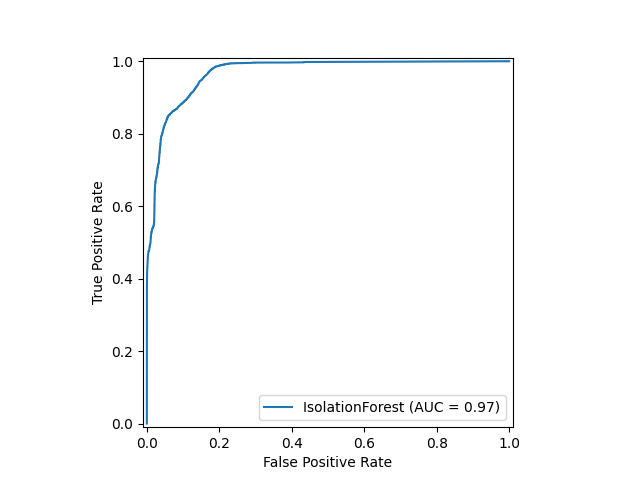

In [168]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

fpr, tpr, thresholds = roc_curve(Y_train, scores)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='IsolationForest')
display.plot()
plt.show()


In [169]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(optimal_threshold)


0.43782709068585873


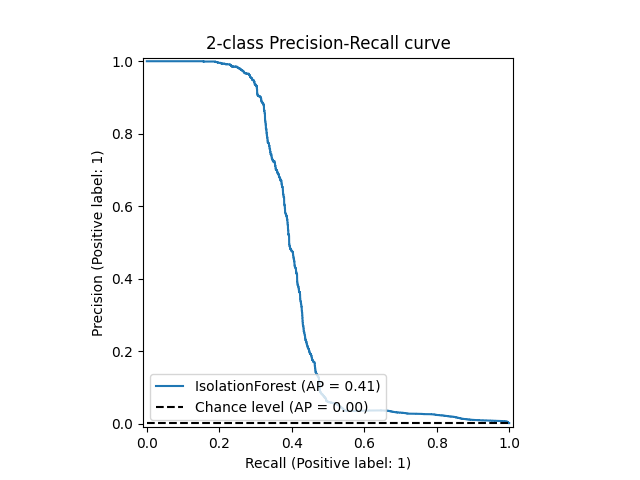

In [170]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(
    Y_train, scores, name="IsolationForest", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")


In [179]:
Y_pred = scores > 0.65


Accuracy: 0.9964723651577495
Precision: 0.17364581538284796
Recall: 0.45851660852419235
F1 Score: 0.25189567536038665
F2 Score: 0.3452410863159818
ROC: 0.727843335096149


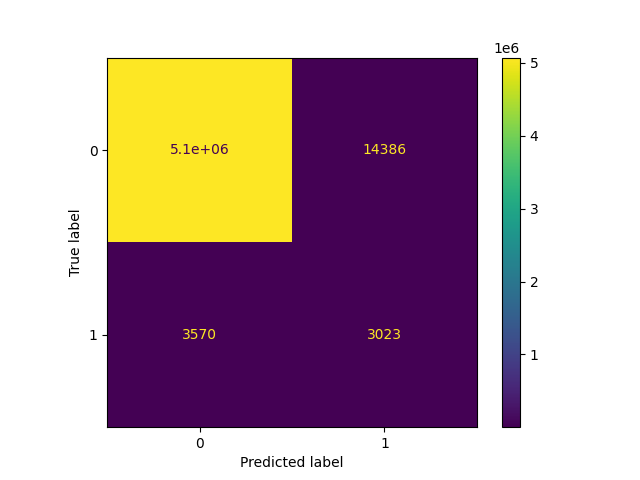

In [180]:
get_scores(Y_train, Y_pred)
display_confusion_matrix(Y_train, Y_pred)
